In [1]:
from glob import glob
import os
import h5py as h5
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.io


from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects

import massPy as mp


from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow
from structure_factor.hyperuniformity import bin_data
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})


In [94]:
def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(Nact):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]
         #   print(i)
         #   print(fit_vals[:,0])
         #   print(fit_err[:,0])
            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)

          #  print("\n",alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
           # print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_sem, beta_sem
   
    return fit_params_sfac_time_av

In [2]:
extract = False

main_dir = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\PhD\\Active Nematic Defect Transition\\guangyin_exp_data\\Antibiotic_Induced_Turbulence_Transition'
save_dir = 'data\\Antibiotic_Induced_Turbulence_Transition'
figs_dir = os.path.join(save_dir, 'figs')
subdirs = glob(os.path.join(main_dir, 'Anti*'))
data_paths = [os.path.join(subdir, subdir.split('\\')[-1] +'.mat') for subdir in subdirs]
act_list = [int(subdir.split('-')[-1].replace('ug', '')) for subdir in subdirs]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

f=h5.File(os.path.join(data_paths[-1]),'r')['orientationData']
variable_names = list(f.keys())

Nact = len(data_paths)
Nframes = len(f[variable_names[0]])
Nx, Ny = f[f[variable_names[1]][0][0]].shape

nx = np.zeros((Nframes, Nx, Ny, Nact))
ny = np.zeros((Nframes, Nx, Ny, Nact))
phi = np.zeros((Nframes, Nx, Ny, Nact))

if extract:
    for j, data_path in enumerate(data_paths):
        f=h5.File(os.path.join(data_paths[j]),'r')['orientationData']

        for i in range(Nframes):
            phi[i, :, :, j] = np.array(f[f[variable_names[1]][i][0]]).astype(float)
            nx[i, :, :, j] = np.array(f[f[variable_names[2]][i][0]]).astype(float)
            ny[i, :, :, j] = np.array(f[f[variable_names[3]][i][0]]).astype(float)
    # Save the data
    np.savez(os.path.join(save_dir, 'data'), phi=phi, nx=nx, ny=ny)
else:
    # Load the data
    data = np.load(os.path.join(save_dir, 'data.npz'))
    phi = data['phi']
    nx = data['nx']
    ny = data['ny']

if extract:
    defect_dict = {}
    ndef_arr = np.zeros((Nframes, Nact),)
    for j, act in enumerate(act_list):
        defects_list = []
        for i in range(Nframes):
            defect_list = mp.base_modules.defects.get_defects(nx[i,:,:,j], ny[i,:,:,j], Nx, Ny, threshold=.4)
            #print(j,i, defect_list)
           # def_arr = get_defect_arr_from_frame(defect_list, return_charge=True)
            ndef_arr[i,j] = len(defect_list)
            defects_list.append(defect_list)
        defect_dict[act] = defects_list
    # save ndef_arr
    np.save(os.path.join(save_dir, 'ndef_arr'), ndef_arr)
    # save defect_dict as pickle
    with open(os.path.join(save_dir, 'defect_dict.pkl'), 'wb') as f:
        pkl.dump(defect_dict, f)
else: 
    # load data
    ndef_arr = np.load(os.path.join(save_dir, 'ndef_arr.npy'), allow_pickle=True)
    with open(os.path.join(save_dir, 'defect_dict.pkl'), 'rb') as f:
        defect_dict = pkl.load(f)


Plot Ndefects over time

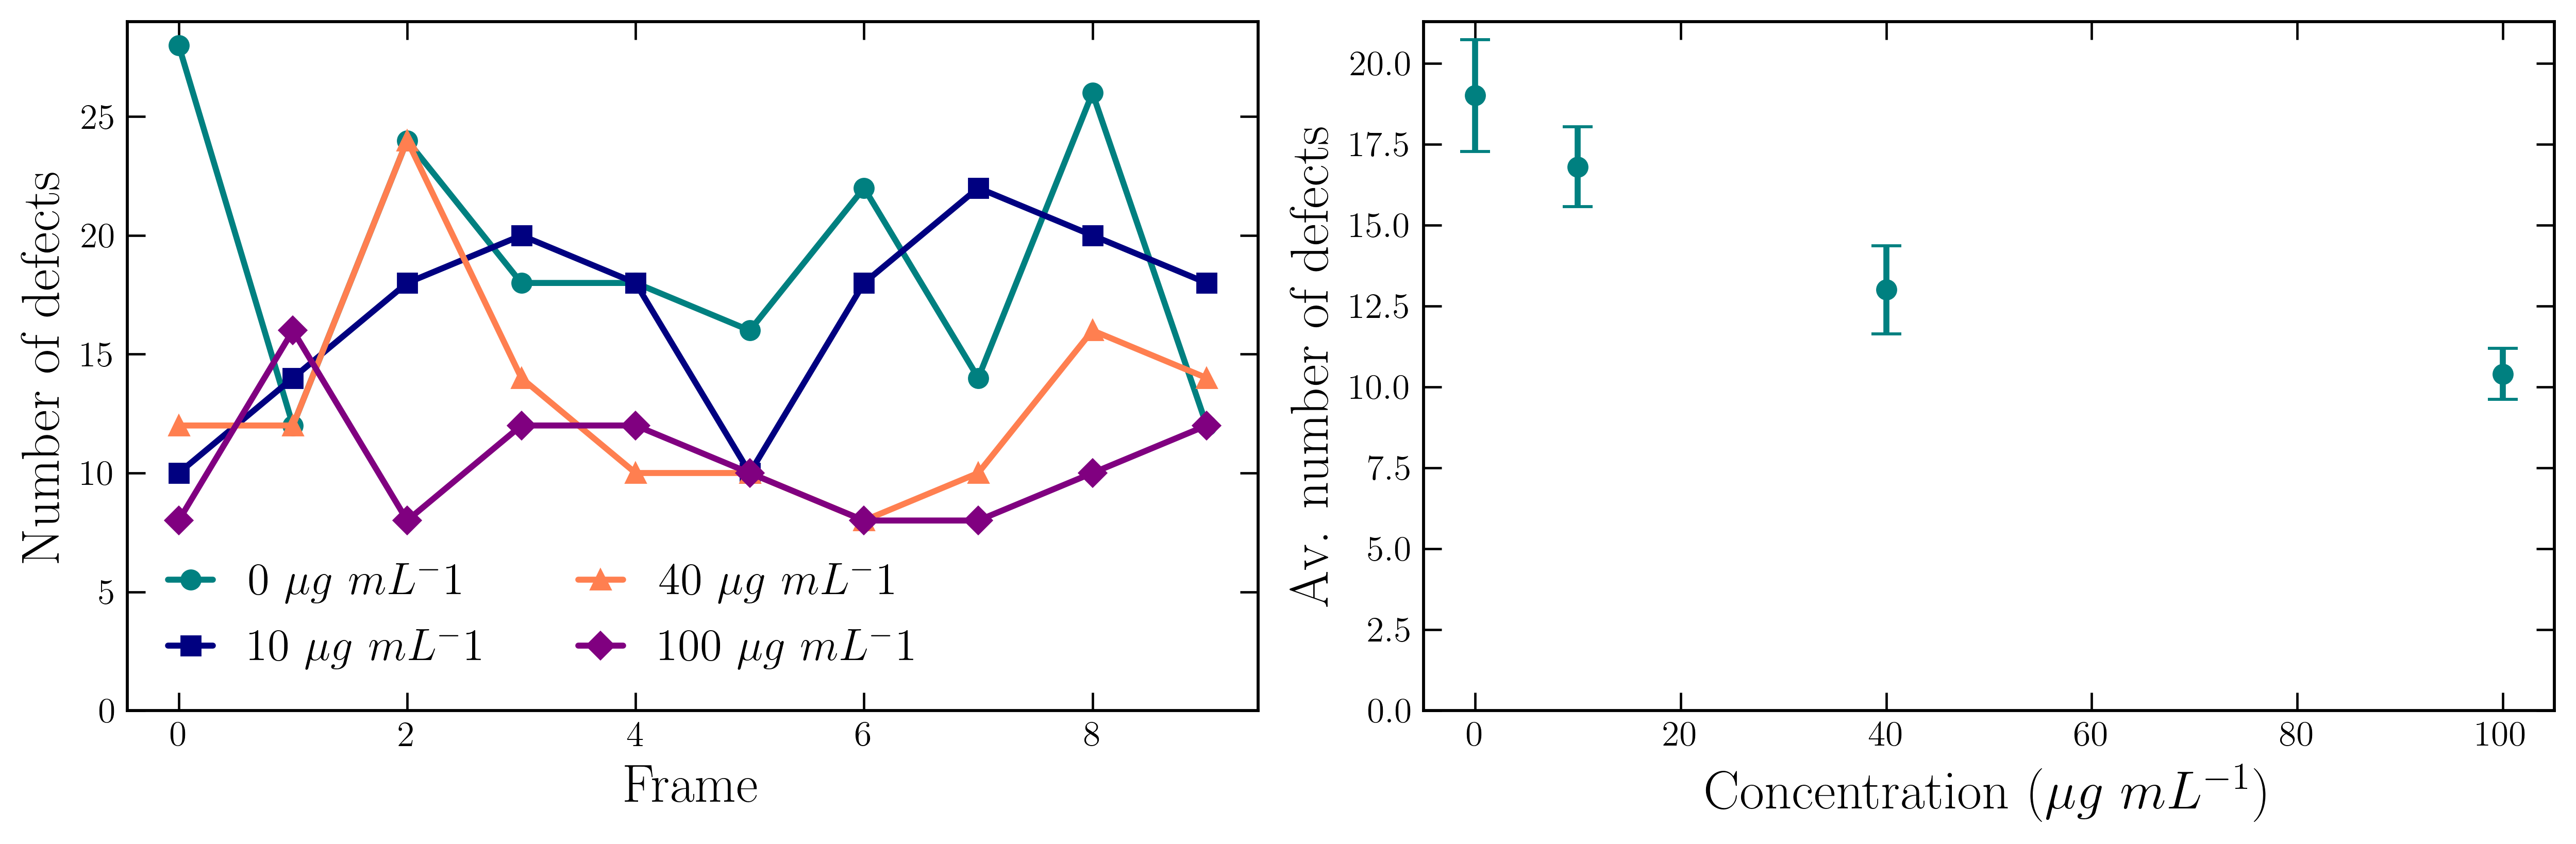

In [ ]:
width=12
fig, ax0 = plt.subplots(ncols=2, figsize=(width,width/3))
ax = ax0[0]
axx = ax0[1]
marker_list = ['o', 's', '^', 'D', 'v', 'p', '*']

for i, act in enumerate(act_list):
    ax.plot(np.arange(Nframes), ndef_arr[:,i], marker=marker_list[i], label = rf'{act} $\mu g ~ mL^{-1}$')

ax.set_ylim(ymin=0)
ax.set_xlabel('Frame')
ax.set_ylabel('Number of defects')
ax.legend(ncols=2)


axx.errorbar(act_list, np.mean(ndef_arr, axis=0), np.std(ndef_arr, axis=0) / np.sqrt(Nframes), fmt='o', capsize=5)
axx.set_ylim(ymin=0)
axx.set_xlabel(r'Concentration ($\mu g ~ mL^{-1}$)')
axx.set_ylabel('Av. number of defects');

fig.savefig(os.path.join(figs_dir, 'ndefects.png'), dpi=520, bbox_inches='tight', pad_inches=0.1)

(0.0, 1.6168421052631579)

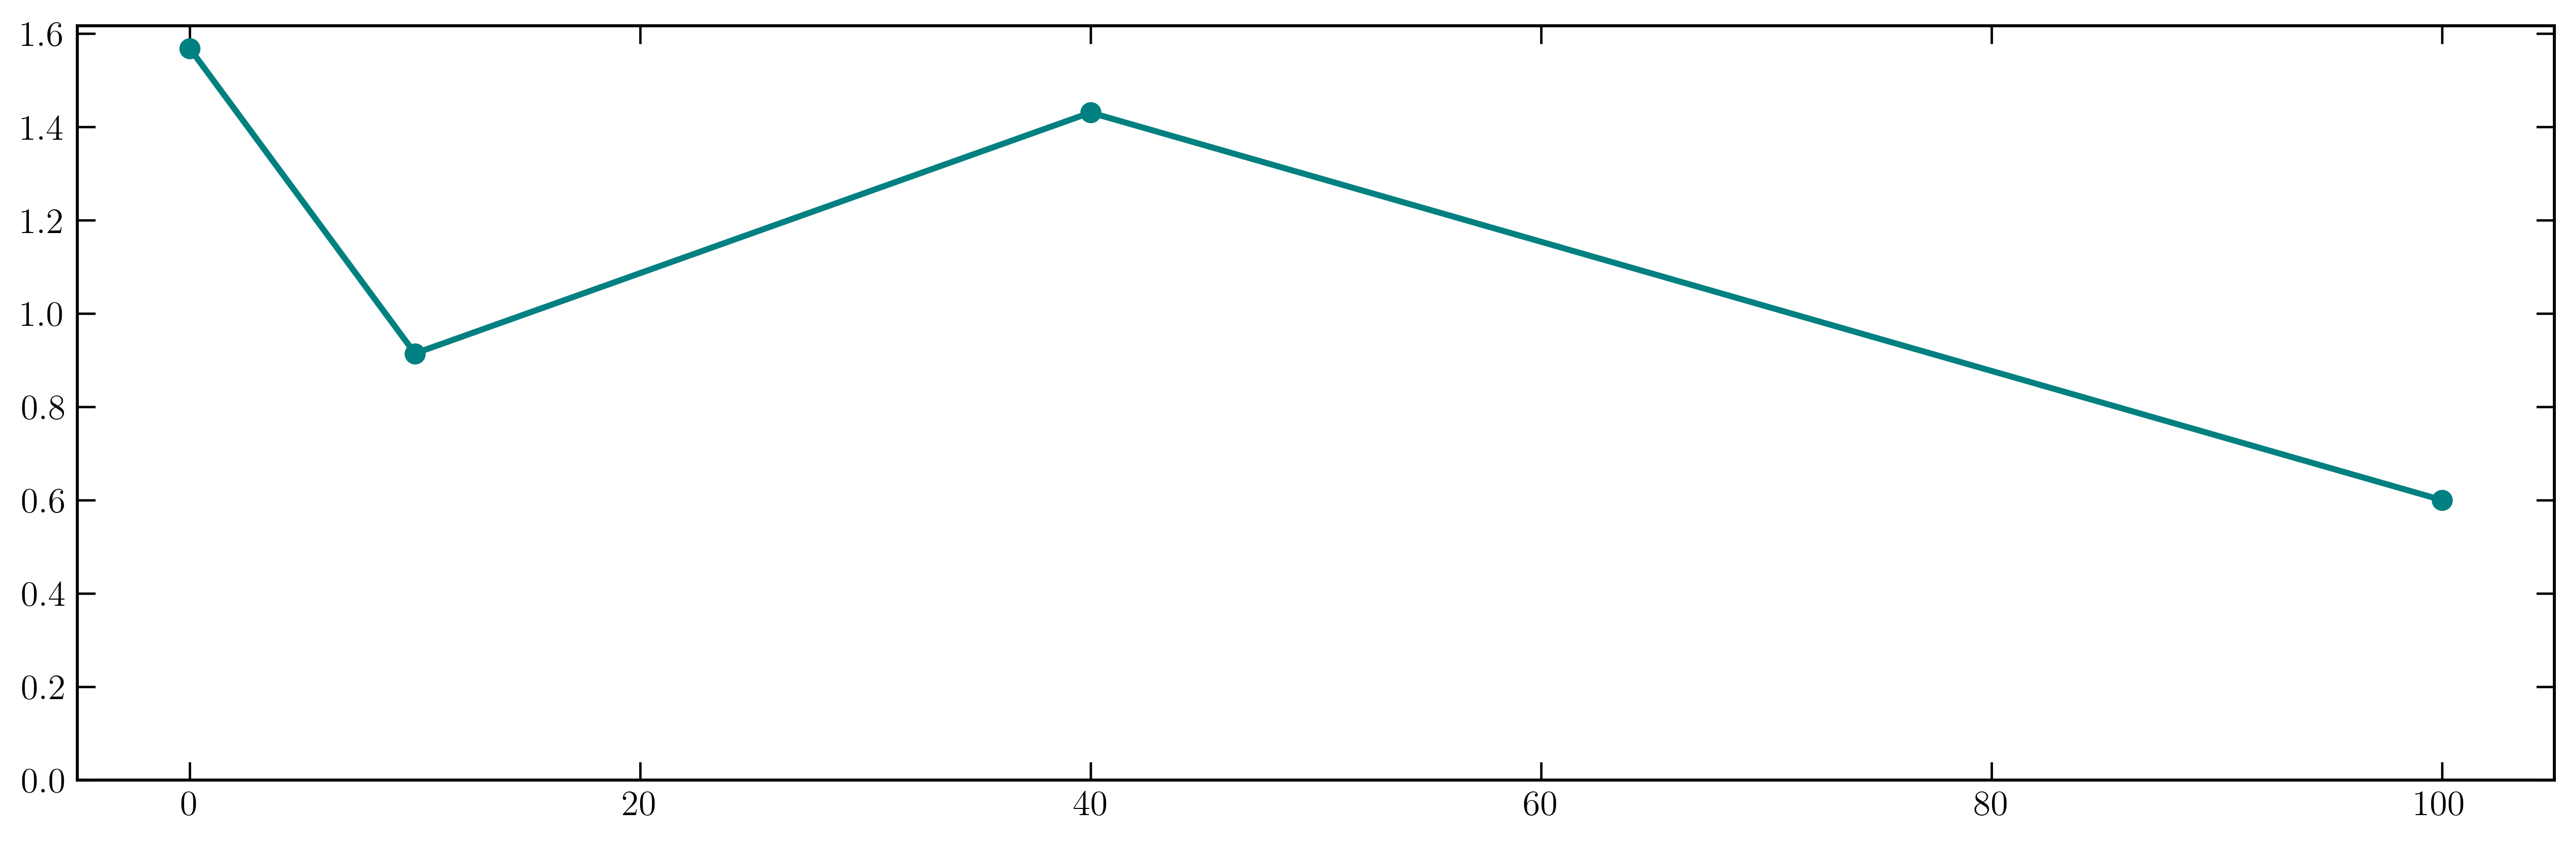

In [85]:
sus = np.zeros((Nact))
for i, act in enumerate(act_list):
    sus[i] = np.var(ndef_arr[:,i]) / np.mean(ndef_arr[:,i])

fig, ax = plt.subplots(figsize=(width,width/3))
ax.plot(act_list, sus, marker='o')
ax.set_ylim(ymin=0)

In [ ]:
# Define sfac parameters
box_window = BoxWindow(bounds=[[0, Nx], [0, Nx]])  
kmax =  1    # 256 / Nx
nbins = 100
sfac_arr = np.zeros((Nframes, nbins, 2, Nact,))
sfac_dict = {}
for i, act in enumerate(act_list):
    top_defects = defect_dict[act]
    kbins, sfac = get_structure_factor(top_defects, box_window, kmax = kmax, nbins = 100,)
    sfac_dict[act] = sfac
    sfac_arr[:, :, :, i] = sfac
#     for i, frame in enumerate(defect_dict[act]):
#         # Get structure factor
#         kbins, sfac = get_structure_factor(frame, box_window, kmax = kmax, nbins = 100,)
#         sfac_dict[act][i] = sfac

# top_defects = defect_dict[act_list[-1]]
# # Get structure factor
# kbins, sfac = get_structure_factor(top_defects, box_window, kmax = kmax, nbins = 100,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100, 4, 2)


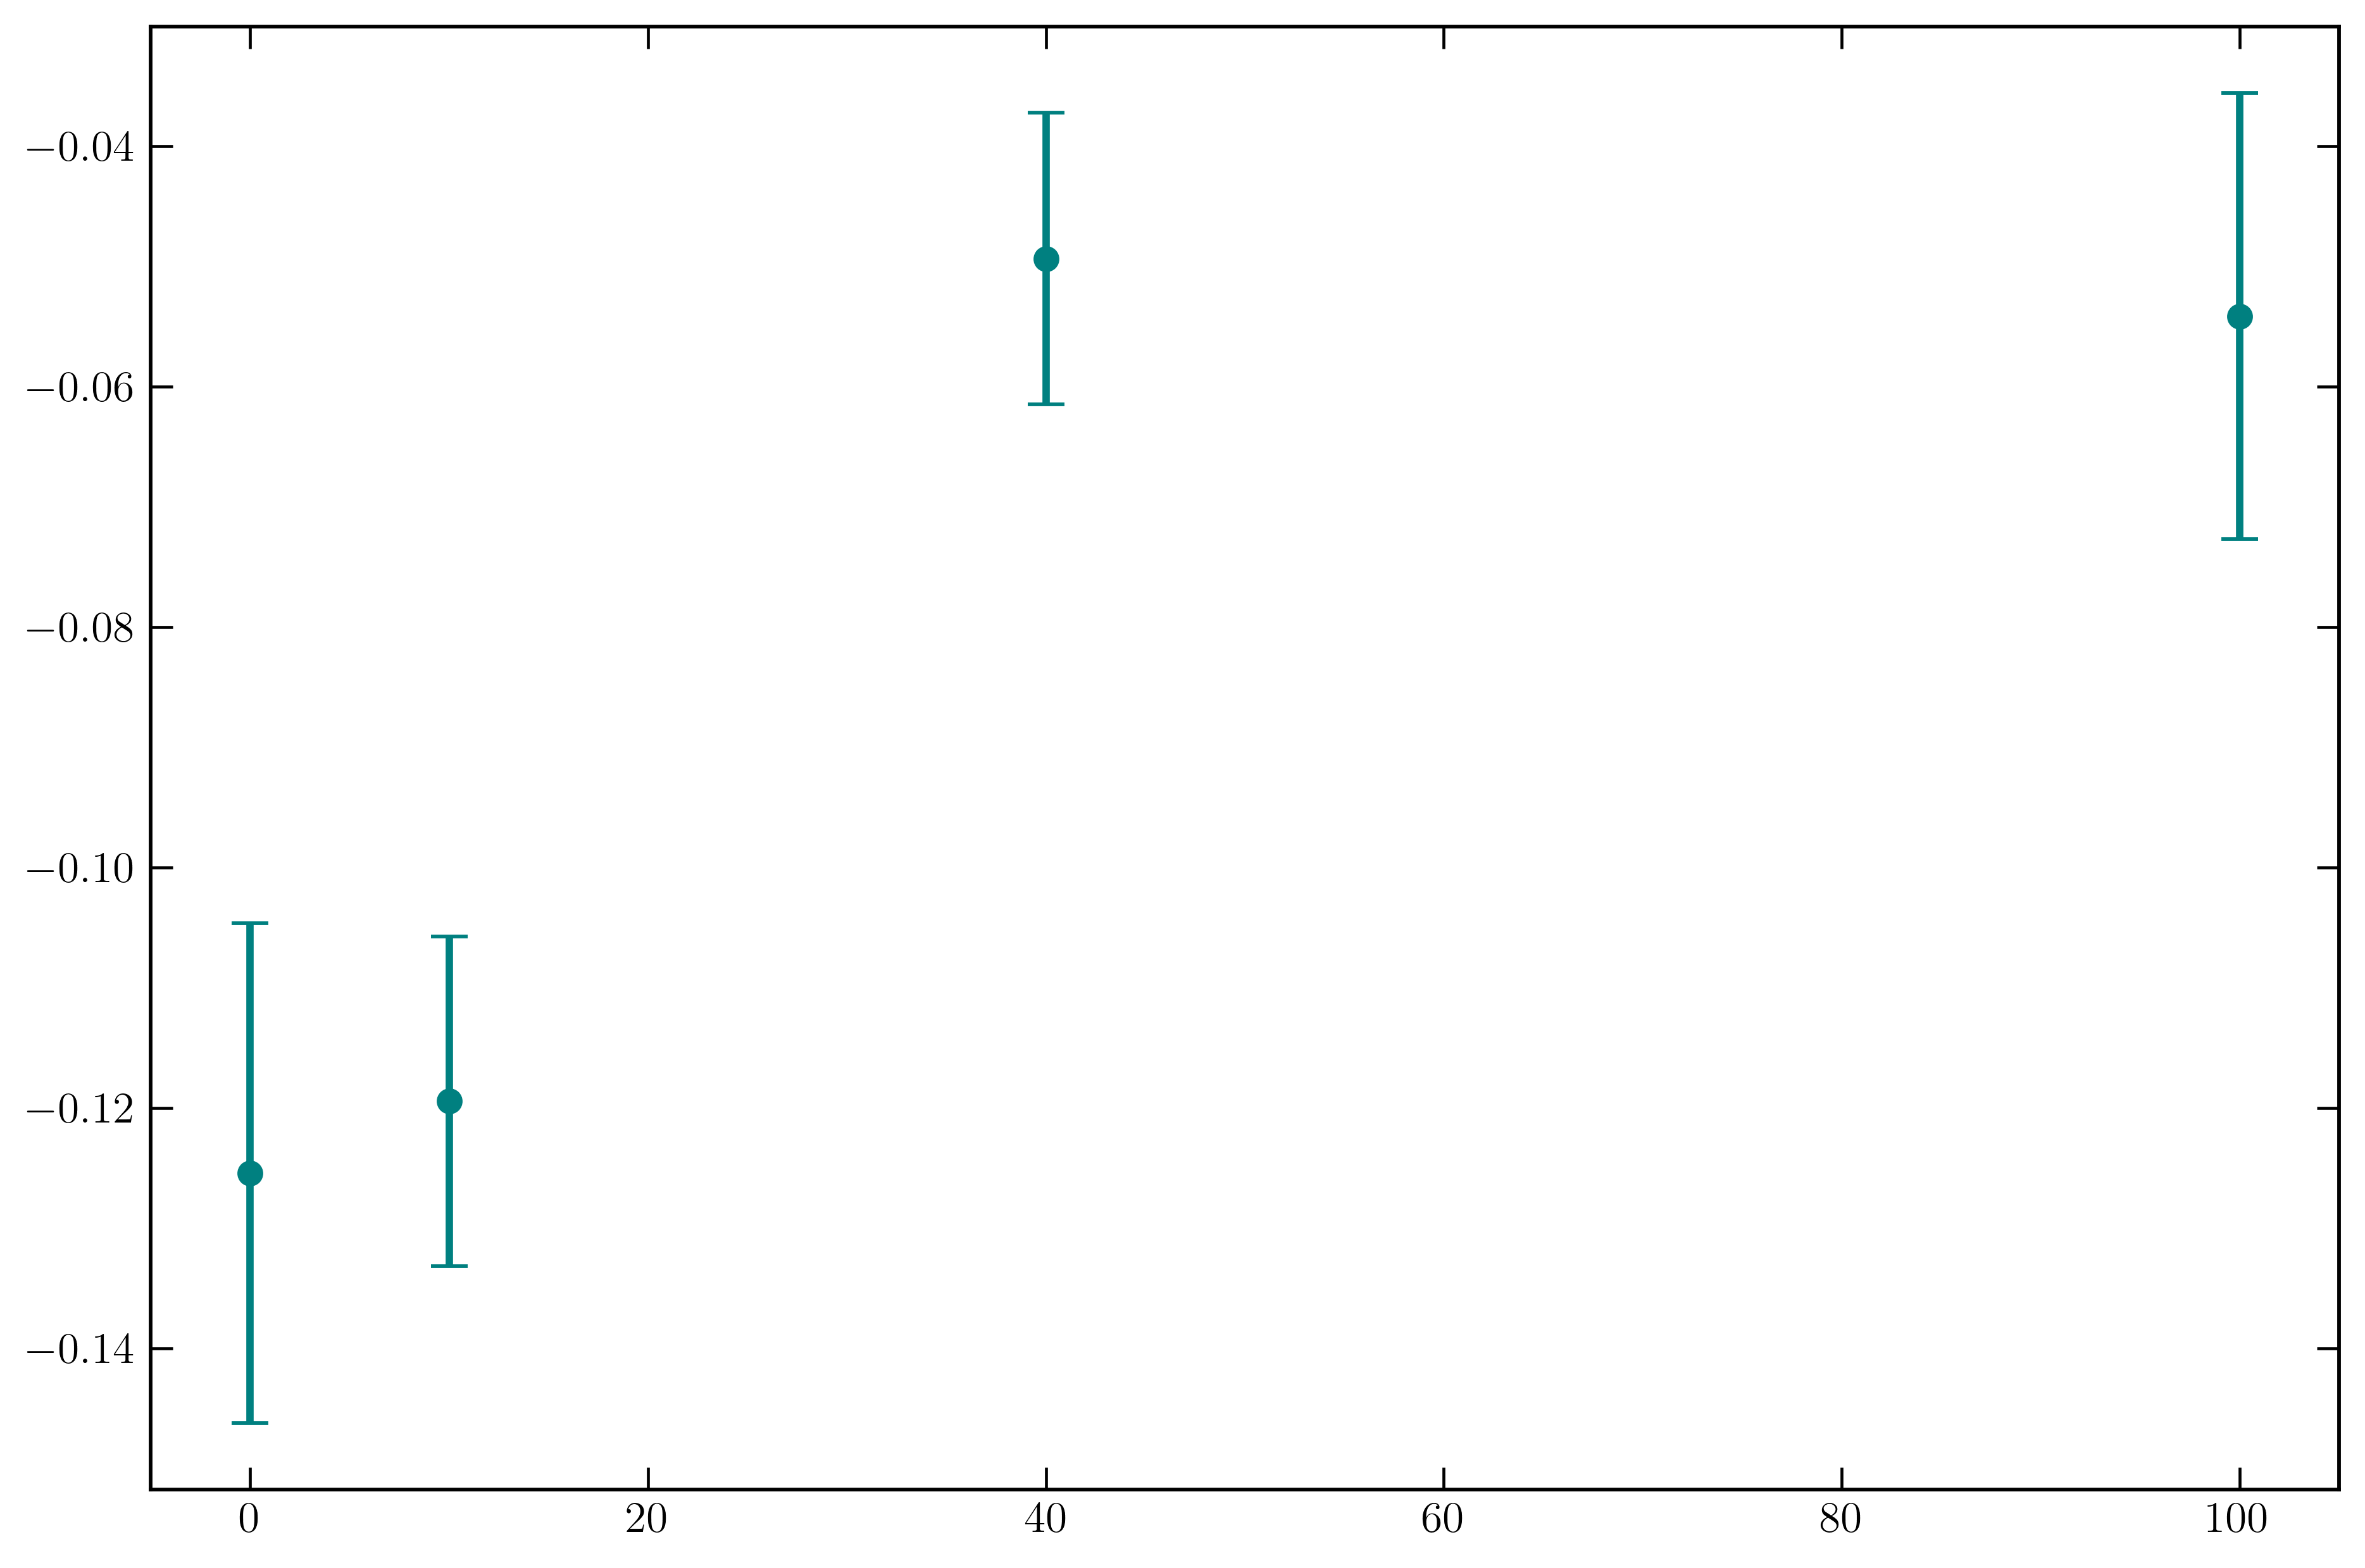

In [ ]:

sfac_av = np.zeros((nbins, Nact, 2))
sfac_av[:,:, 0] = np.nanmean(sfac_arr[:,:,0,:], axis = 0)
sfac_av[:,:, 1] = (np.nanstd(sfac_arr[:,:,0,:], axis = 0)) / np.sqrt(Nframes) # + np.nanmean(sfac_arr[:,:,1,:], axis = 0)) / np.sqrt(Nframes)


avw, stdw = calc_weighted_mean(sfac_arr[:,:,0,:], sfac_arr[:,:,1,:], axis=0)
sfac_avw = np.concatenate((avw[:,:, np.newaxis], stdw[:,:, np.newaxis]), axis = -1)
print(sfac_avw.shape)

fitp = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [25,27],)
fitpw =  analyze_sfac_time_av(kbins, sfac_avw, Npoints_bounds = [25,27],)

fig, ax = plt.subplots()
ax.errorbar(act_list, fitp[:,0], yerr = fitp[:,2], fmt='o', capsize=5)
#ax.errorbar(act_list, fitpw[:,0], yerr = fitpw[:,2], fmt='o', capsize=5, label = 'Weighted')
ax.legend()

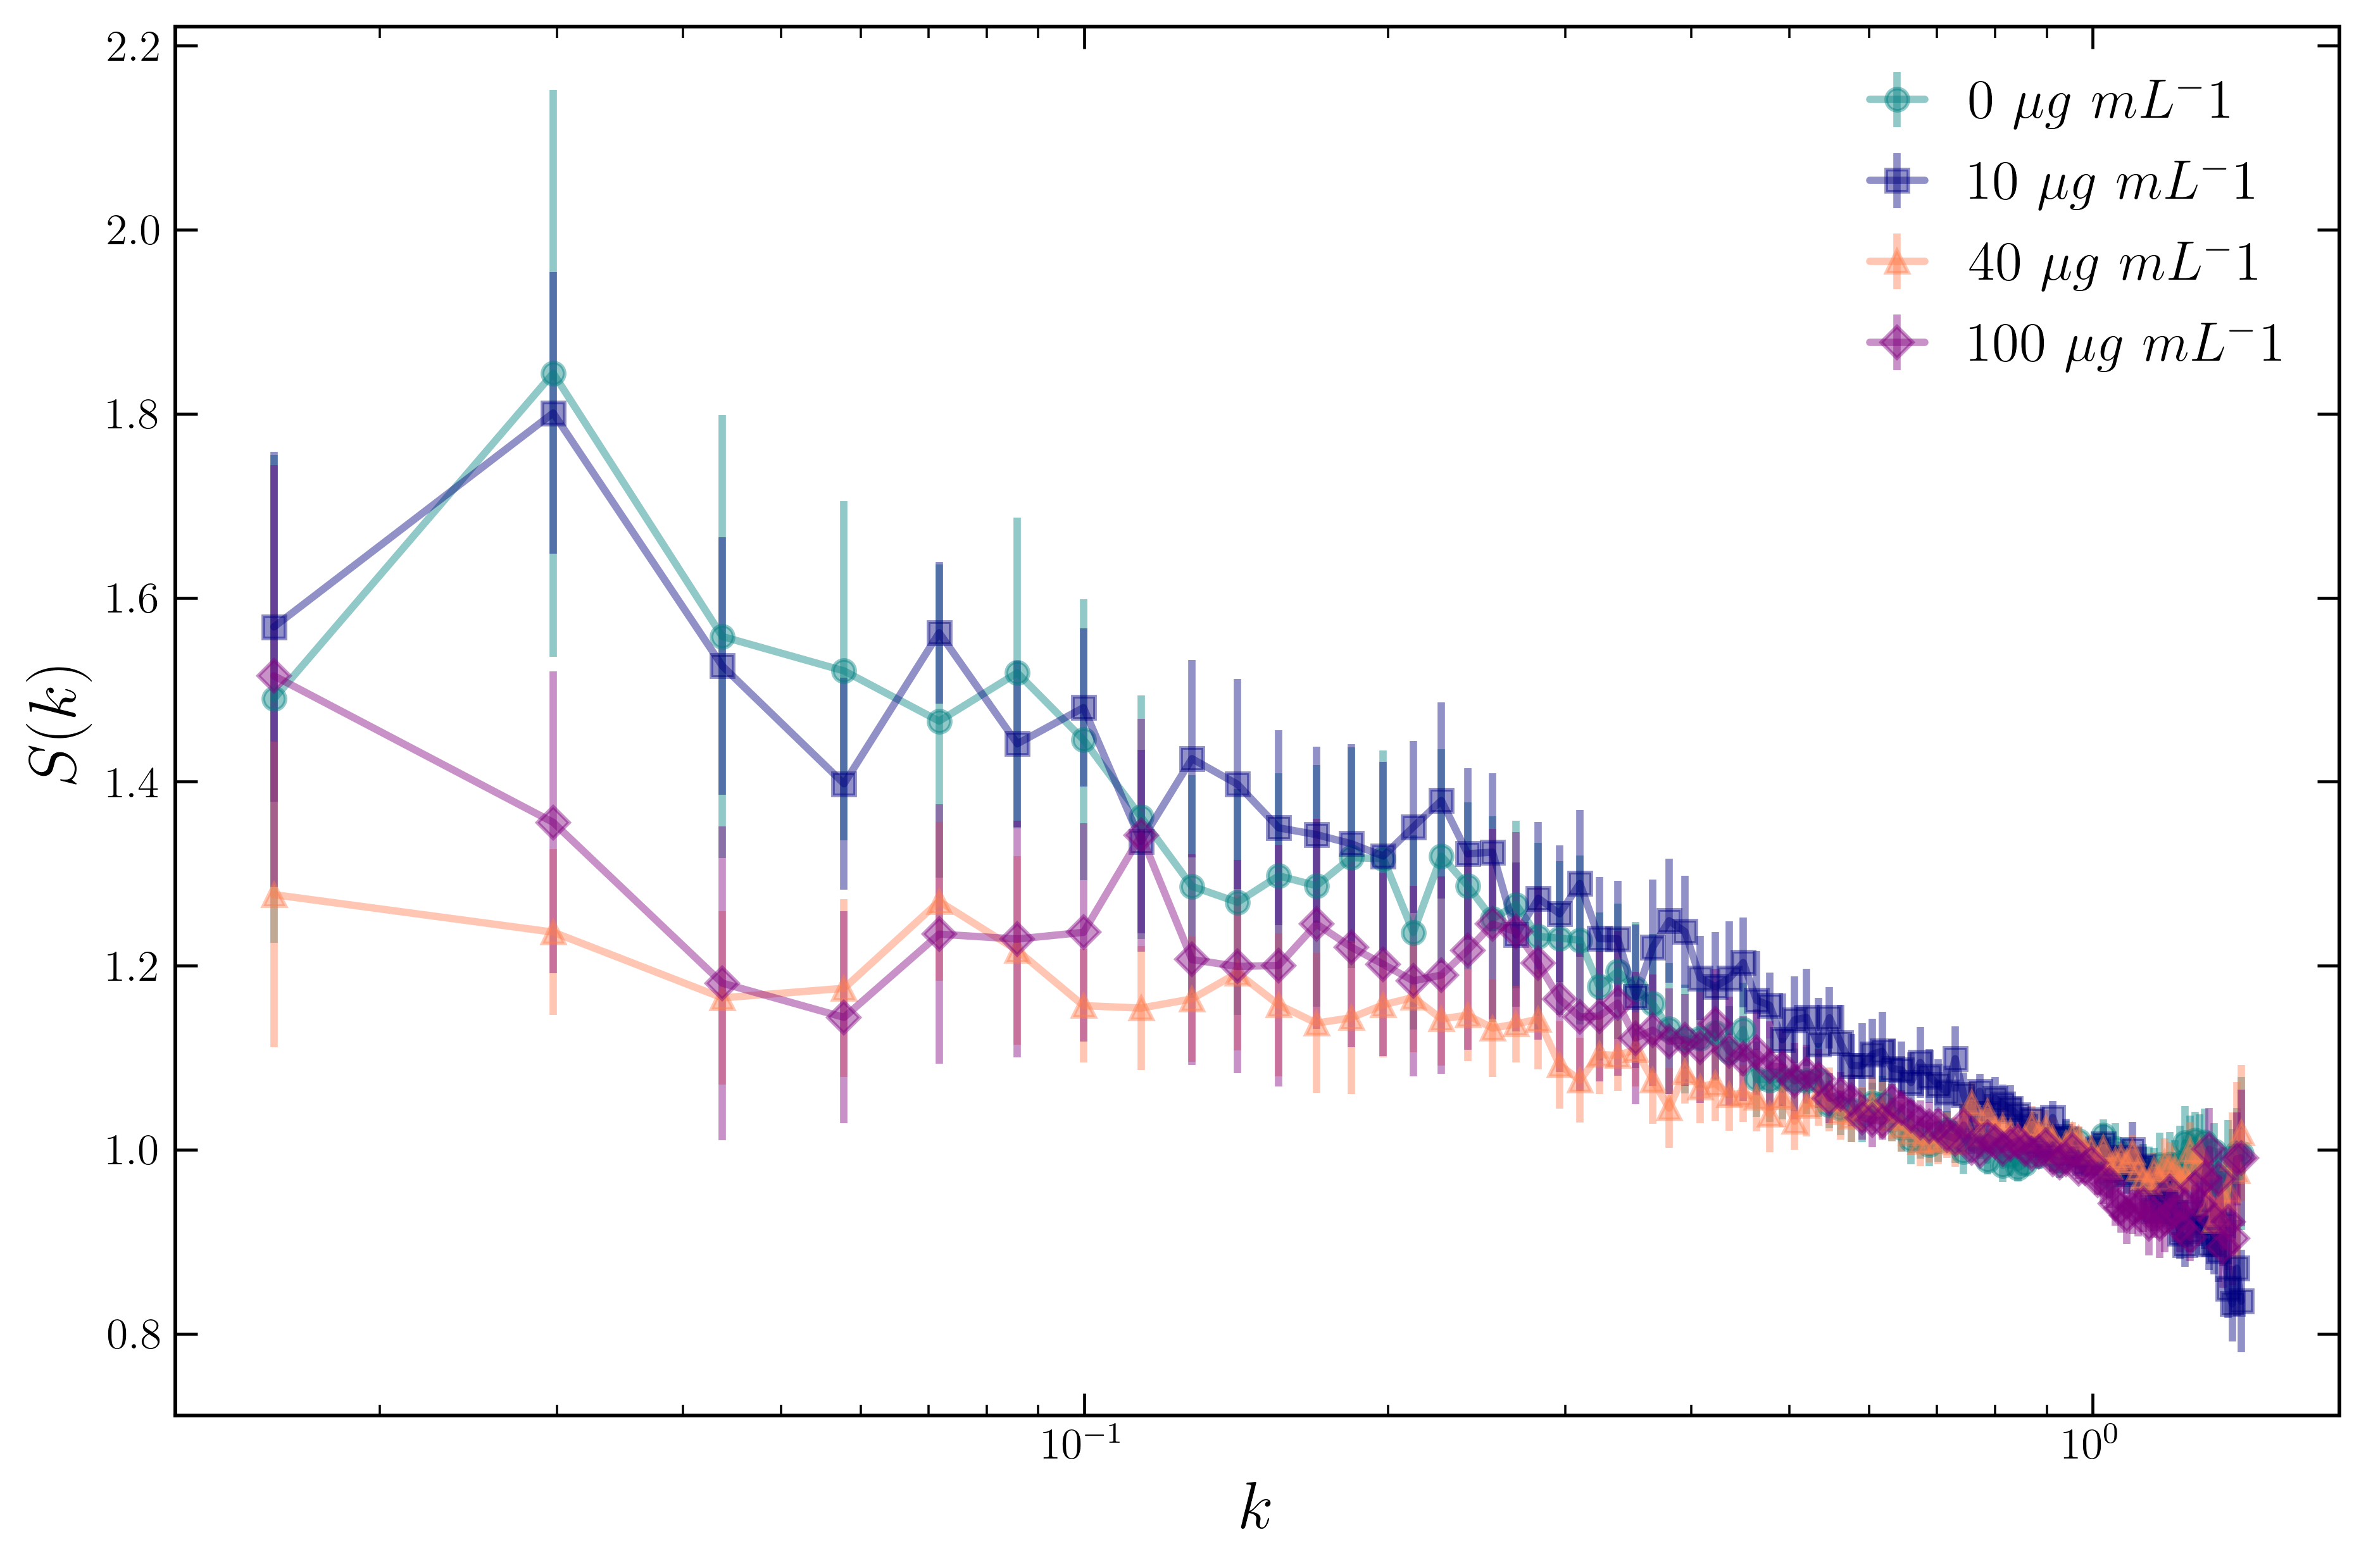

In [ ]:
width=9
marker_list = ['o', 's', '^', 'D', 'v', 'p', '*']
sfac_av = np.zeros((nbins, 2, Nact))
sfac_av[:,0,:] = np.nanmean(sfac_arr[:,:,0,:], axis = 0)
sfac_av[:,1,:] = (np.nanstd(sfac_arr[:,:,0,:], axis = 0)) / np.sqrt(Nframes) # + np.nanmean(sfac_arr[:,:,1,:], axis = 0)) / np.sqrt(Nframes)
fig, ax = plt.subplots()
for i, act in enumerate(act_list):
    ax.errorbar(kbins, sfac_av[:,0,i], yerr=sfac_av[:,1,i],
                 label = rf'{act} $\mu g ~ mL^{-1}$', marker = marker_list[i], alpha=.43)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$S(k)$')
#ax.set_xlim(xmin=0)
#ax.set_ylim(ymin=0)
ax.set_xscale('log')
ax.legend()


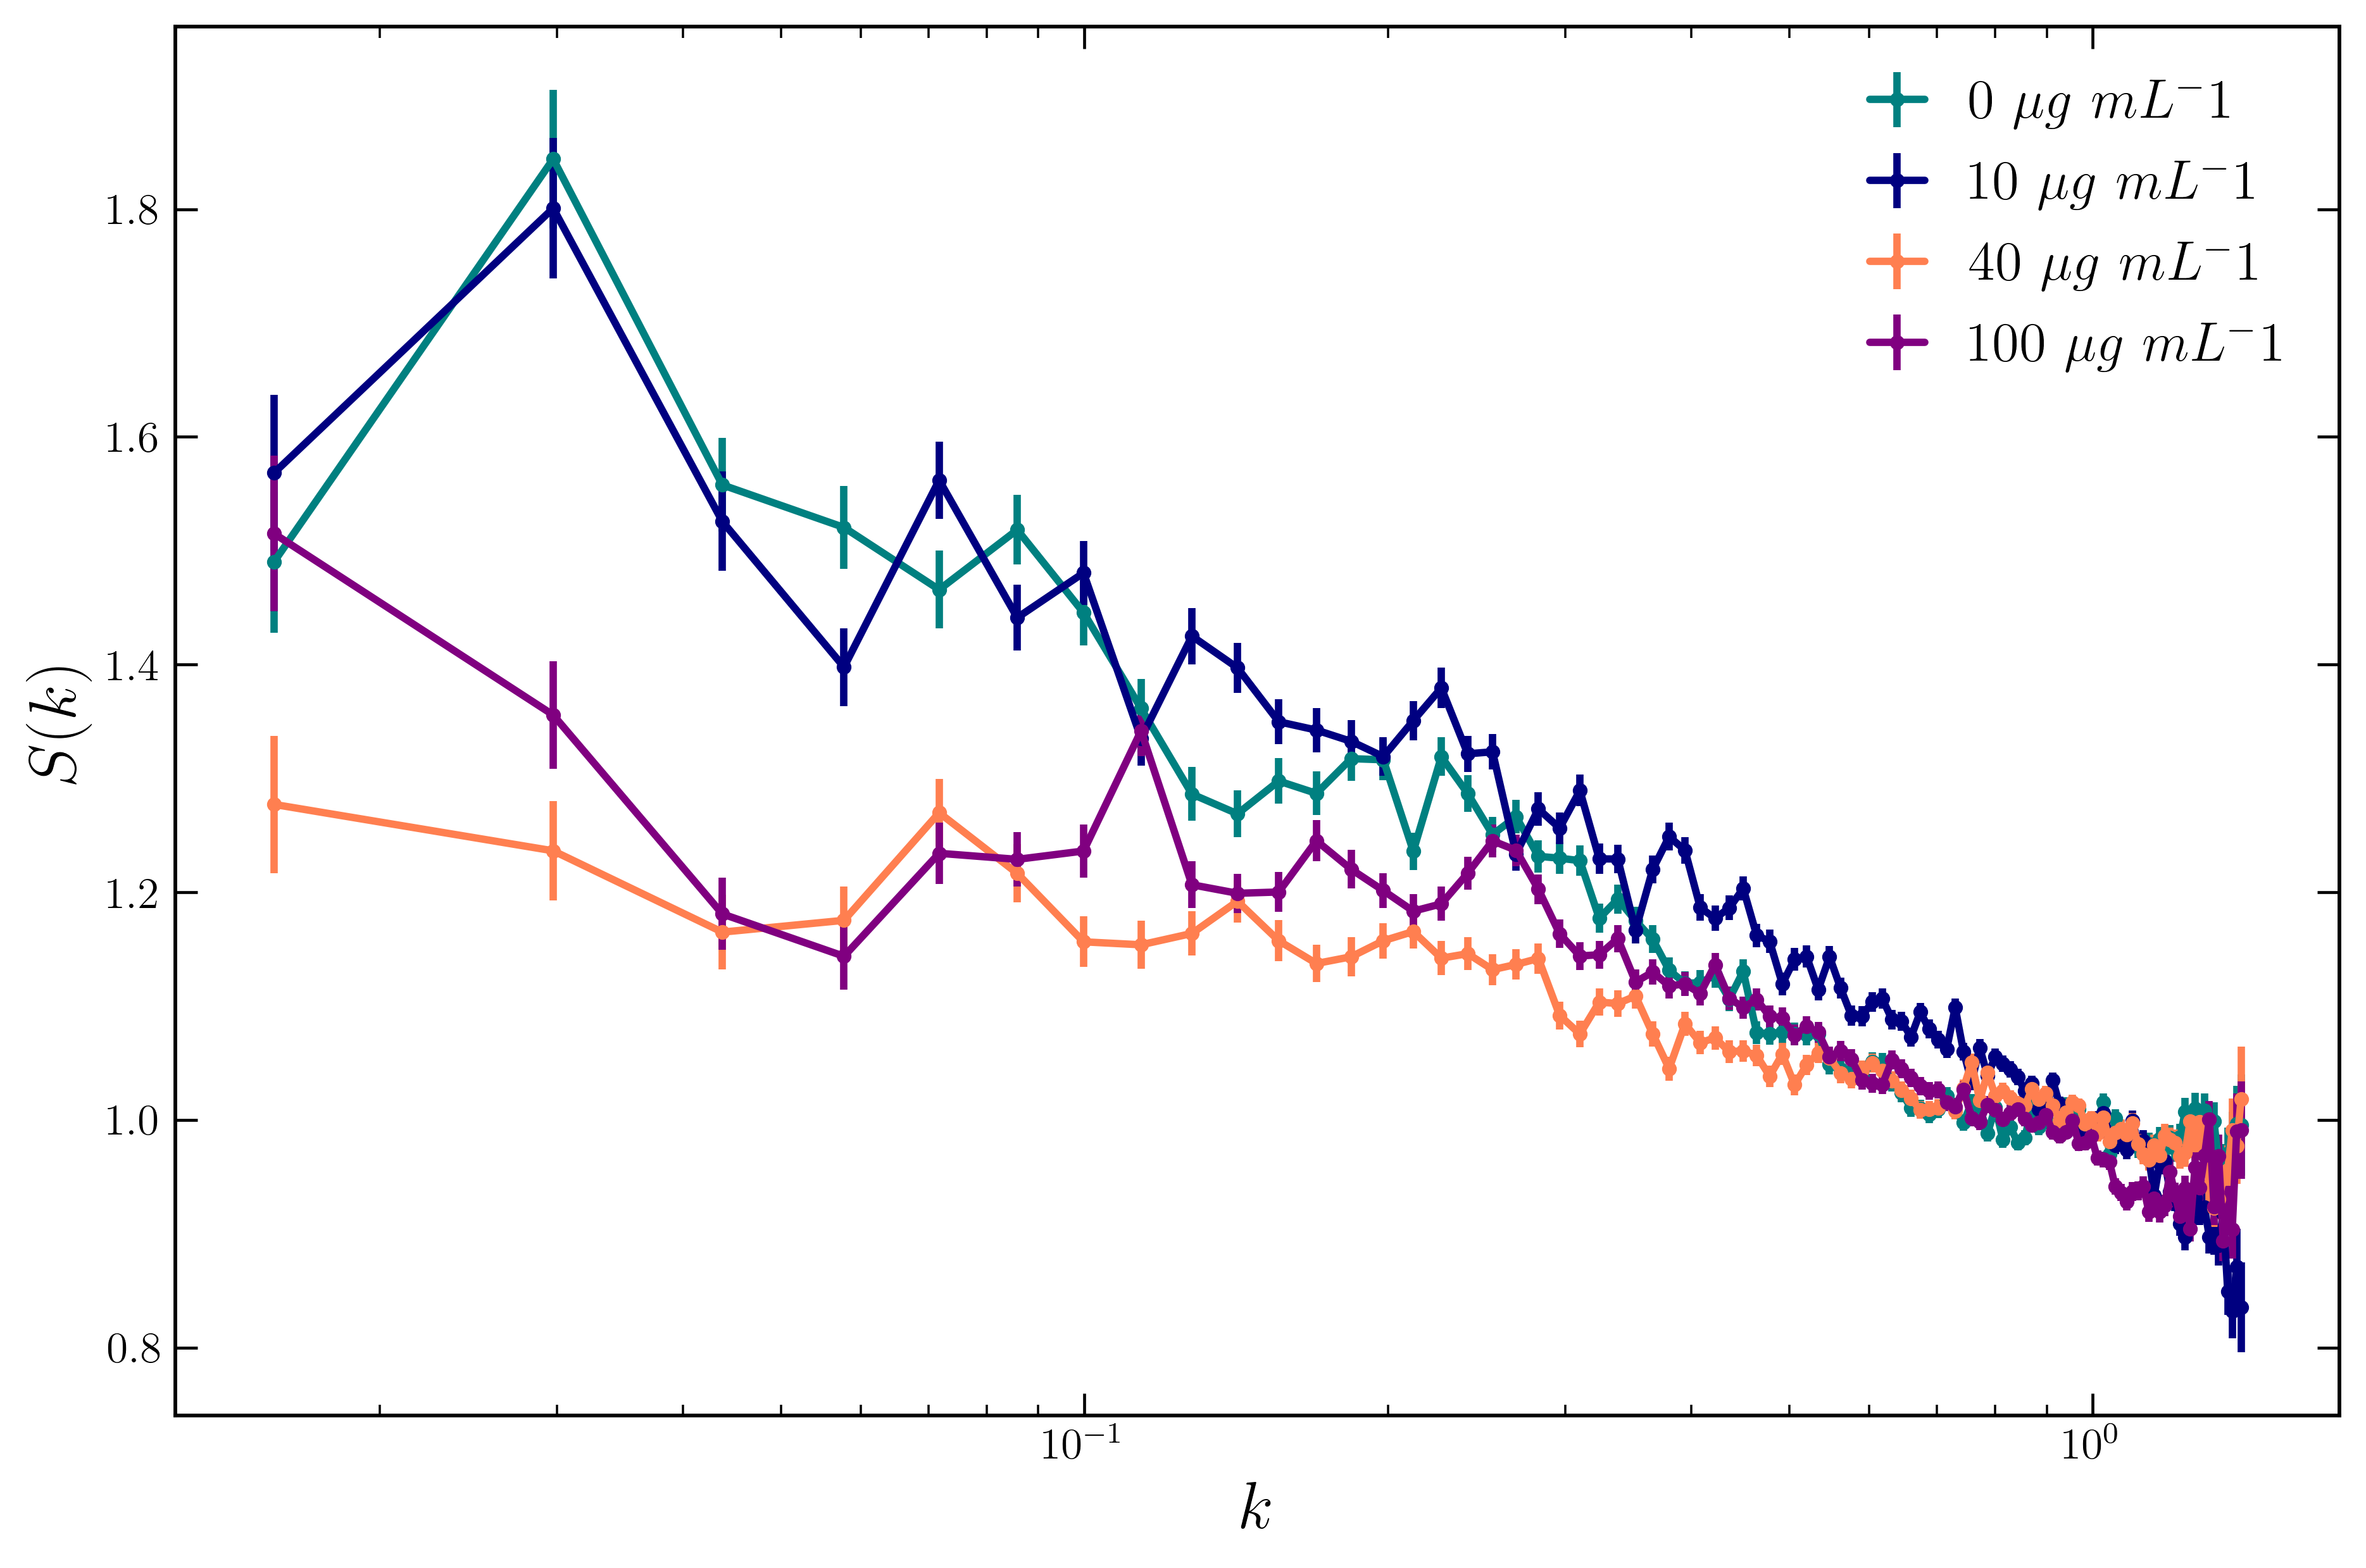

In [27]:
fig, ax = plt.subplots()

for i, act in enumerate(act_list):
    sfac = sfac_dict[act]
    ax.errorbar(kbins, np.nanmean(sfac[:,:,0], axis = 0), np.nanmean(sfac[:,:,1], axis = 0) / np.sqrt(Nframes), 
                fmt='.-', label = rf'{act} $\mu g ~ mL^{-1}$')
ax.legend()
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$S(k)$')
ax.set_xscale('log')
#ax.set_yscale('log')